# <div style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:200%; text-align:center;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0">Santa 2023 - Genetic Algorithm</div>
#### <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:150%; text-align:left;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0" >TABLE OF CONTENTS<br><div>
* [IMPORTS](#1)
* [LOAD DATA](#2)
* [EDA AND VISUALS](#3)
* [FEATURE ENGINEERING](#4)
* [MODEL](#5)

<a id="1"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:120%; text-align:left;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0" > IMPORTS<br><div> 

In [1]:
import pandas as pd
from ast import literal_eval
from dataclasses import dataclass
import random
from sympy.combinatorics import Permutation
from typing import Dict, List
import zipfile
import numpy as np
import sqlite3

<a id="2"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:120%; text-align:left;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0" > LOAD DATA<br><div> 

In [2]:
with zipfile.ZipFile('../../../res/data/santa-2023.zip', 'r') as z:
    
    with z.open('puzzle_info.csv') as f:
        puzzle_info = pd.read_csv(f, index_col = 'puzzle_type')        
                
    with z.open('puzzles.csv') as f:
        puzzles = pd.read_csv(f, index_col = 'id')
    
    with z.open('sample_submission.csv') as f:
        submission = pd.read_csv(f)

<a id="3"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:120%; text-align:left;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0" > EDA AND VISUALS<br><div> 

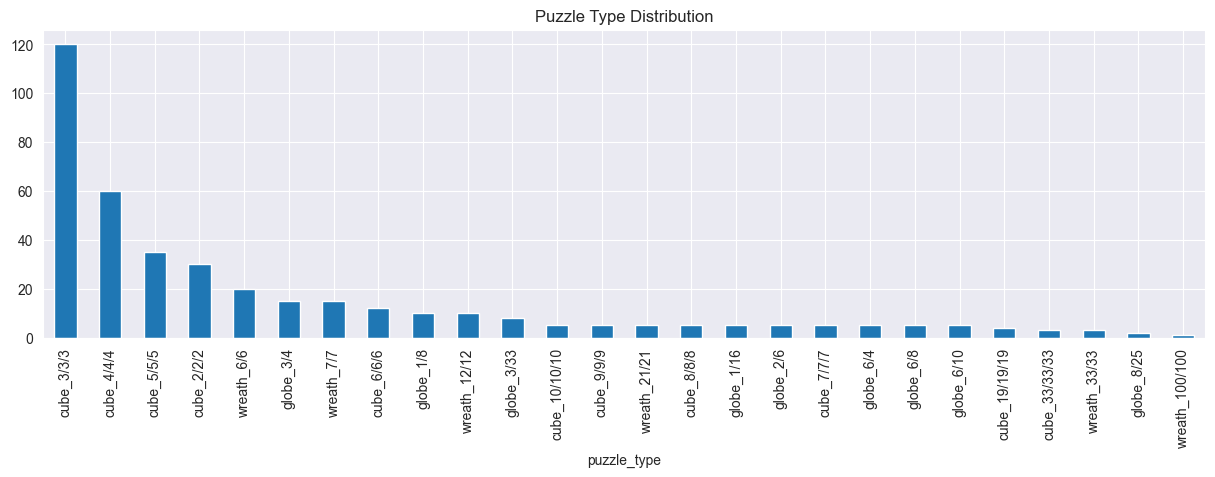

In [3]:
puzzles['puzzle_type'].value_counts().plot(kind='bar', title='Puzzle Type Distribution', figsize=(15,4));

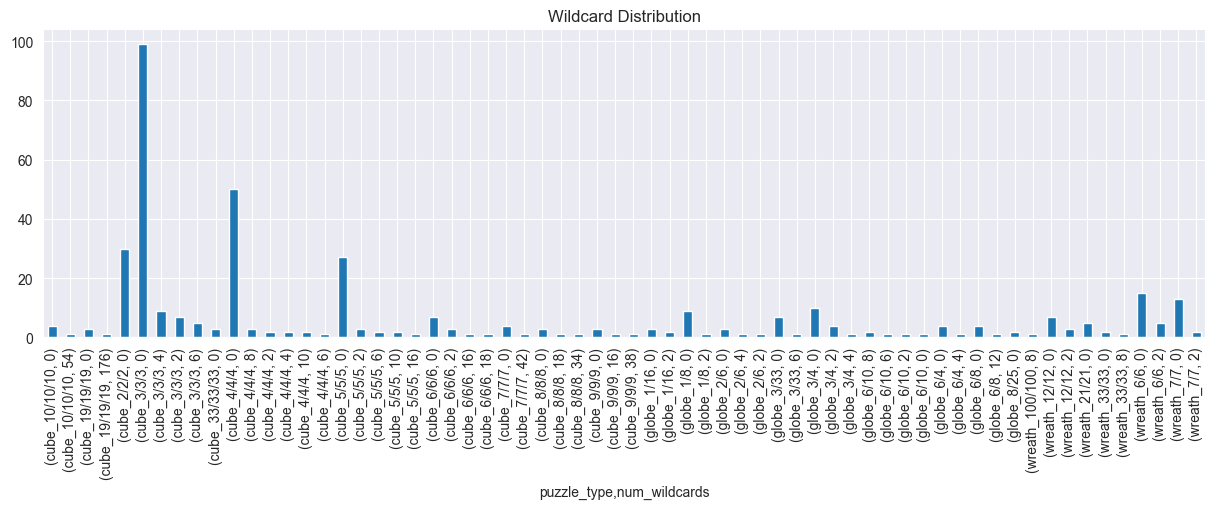

In [4]:
puzzles.groupby(['puzzle_type'])['num_wildcards'].value_counts().plot(kind='bar', title='Wildcard Distribution', 
                                                                      figsize=(15,4));

<a id="4"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:120%; text-align:left;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0" > FEATURE ENGINEERING<br><div> 

<a id="5"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:120%; text-align:left;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0" >Model<br><div> 

In [31]:
def invert_move(move_permutation):
    """
    Inverts a given move permutation.
    
    Args:
    move_permutation (list): A list of indices representing a move.

    Returns:
    list: The inverse permutation.
    """
    inverse_permutation = [0] * len(move_permutation)
    for i, p in enumerate(move_permutation):
        inverse_permutation[p] = i
    return inverse_permutation

def choose_two_random_ints(N):
    """Choose two unique random integers from 0 to N (inclusive)."""
    # Check if N is large enough to choose two unique integers
    if N < 2:
        raise ValueError("N must be at least 2 to choose two unique integers.")

    # Randomly select two unique integers
    return random.sample(range(N), 2)

def create_individual(length, allowed_moves, known_solution=None, mutation_rate=0.1):
    """Create a random individual as a sequence of moves."""
    allowed_moves_keys = list(allowed_moves.keys())
    if known_solution is None:
        individual = [random.choice(allowed_moves_keys) for _ in range(length)]
    else:
        individual = known_solution.copy()
        
        for i in range(len(individual)):
            if random.random() < mutation_rate:
                # print(individual, i, allowed_moves)
                individual[i] = random.choice(allowed_moves_keys)

    return individual

def apply_moves(cube_state, moves, allowed_moves):
    """Apply a sequence of moves to the cube."""
    new_state = cube_state.copy()
    # print(moves)
    for move in moves:
        new_state = [new_state[i] for i in allowed_moves[move]]
    return new_state

def apply_moves_and_check(cube_state, solution_state, target_fitness, moves, allowed_moves):
    """Apply a sequence of moves to the cube."""
    new_state = cube_state.copy()
    # print(moves)
    for idx, move in enumerate(moves):
        new_state = [new_state[i] for i in allowed_moves[move]]
        fitness = compute_fitness(new_state, solution_state)
        if fitness >= target_fitness:
            # print('solution found')
            moves = moves[:idx+1]
            break
    return new_state, moves

def compute_fitness(cube_state, solution_state):
    """Compute the fitness of a cube state. Higher is better."""
    # Fitness can be the number of pieces in the correct position and orientation
    # solution_state = ['A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'D', 'D', 'D', 'D', 'E', 'E', 'E', 'E', 'F', 'F', 'F', 'F']
    return sum([1 for i in range(len(solution_state)) if cube_state[i] == solution_state[i]])

def select_parents(population, fitnesses, num_parents):
    """Select parents for crossover."""
    parents = random.choices(population, weights=fitnesses, k=num_parents)
    return parents

def crossover(parent1, parent2):
    """Perform crossover between two parents."""
    if (len(parent1) > 1) & (len(parent2) > 1):
        crossover_index = random.randint(1, min([len(parent1), len(parent2)]) - 1)
        child1 = parent1[:crossover_index] + parent2[crossover_index:]
        child2 = parent2[:crossover_index] + parent1[crossover_index:]
    else:
        child1 = parent1
        child2 = parent2
    return child1, child2

def mutate(individual, mutation_rate, swap_rate, drop_rate, add_rate, moves):
    """Mutate an individual."""
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            individual[i] = random.choice(moves)
            
    
    # move_count = len(individual)
    # if (random.random() < swap_rate) and (move_count >= 2):
    #     i, j = choose_two_random_ints(move_count)
    #     # Swap the elements
    #     individual[i], individual[j] = individual[j], individual[i]
        
    # #drop or add, but not both
    # if (random.random() < drop_rate) and (move_count >= 2):
    #     individual.pop(random.randint(0, move_count - 1))        
    # elif (random.random() < add_rate):
    #     individual.append(random.choice(moves))
    return individual

def genetic_algorithm(initial_state, solution_state, population_size, individual_length, 
                      num_generations, 
                      mutation_rate, swap_rate, drop_rate, add_rate, allowed_moves, target_fitness, 
                      known_solution=None, game_id=None, verbose=False):
    allowed_moves_keys = list(allowed_moves.keys())
    
    # Initialize population and the cube's solution state
    population = [create_individual(individual_length, allowed_moves, known_solution=known_solution) for _ in range(population_size)]
    next_generation = population
    solved = False
    for generation in range(num_generations):
        population = next_generation
        # Compute fitness for each individual
        # fitnesses = [compute_fitness(apply_moves(initial_state, individual, allowed_moves), solution_state) for individual in 
        #              population]
        states_and_moves = [apply_moves_and_check(initial_state, solution_state, target_fitness, individual, 
                                               allowed_moves) for individual in population]
        fitnesses = [compute_fitness(new_state, solution_state) for new_state, individual_moves in states_and_moves]
        if max(fitnesses) >= target_fitness: 
            
            fitnesses = [compute_fitness(new_state, solution_state ) for new_state, individual_moves in 
                         states_and_moves]
            population = [remove_similar_pairs(individual_moves) for new_state, individual_moves in states_and_moves]
            # make sure solution shorter...
            best_individual = find_shortest_string_above_threshold(fitnesses, target_fitness, population)
            best_fitness = max(fitnesses)
            if verbose:
                print(f"ID: {game_id}: Best Fitness = {best_fitness}, Moves {len(best_individual)}")

            if len(best_individual) < len(known_solution):
                solved = True
                break
            
        # Select parents
        parents = select_parents(population, fitnesses, population_size // 2)
        # print(parents)
        # Create next generation
        next_generation = []
        for i in range(0, len(parents), 2):
            parent1, parent2 = parents[i], parents[i+1]
            child1, child2 = crossover(parent1, parent2)
            next_generation.extend([mutate(child1, mutation_rate, swap_rate, drop_rate, add_rate, allowed_moves_keys),
                                    mutate(child2, mutation_rate, swap_rate, drop_rate, add_rate, allowed_moves_keys)])        
            
        

    # Return the best individual from the final generation
    # need to handle case when no moves present after reducing?
    if not solved:
        population = [remove_similar_pairs(item) for item in population]
        best_fitness = max(fitnesses)
        best_individual = population[fitnesses.index(best_fitness)]
    return best_individual, best_fitness, solved

def remove_similar_pairs(lst):
    i = 0
    while i < len(lst) - 1:
        current = lst[i]
        next_element = lst[i + 1]

        # Check if the next element is similar to the current element
        if current == '-' + next_element or '-' + current == next_element:
            # Remove both elements
            del lst[i:i + 2]
            # Step back to account for the removed elements
            i = max(0, i - 1)
        else:
            i += 1

    return lst

In [32]:
def find_shortest_string_above_threshold(fitnesses, threshold, population):
    # Ensure the lists are of equal length
    if len(fitnesses) != len(population):
        raise ValueError("Lists must be of the same length.")
    
    # Find indices of all values in fitnesses that are >= threshold
    valid_indices = [i for i, num in enumerate(fitnesses) if num >= threshold]
    
    # Extract the corresponding strings from population
    valid_sequences = [population[i] for i in valid_indices]
    
    # Find the shortest string among the valid strings
    if not valid_sequences:  # If the list is empty, return an indication
        return "No valid strings found."
    shortest_list = min(valid_sequences, key=len)  # Find the shortest list
    
    return shortest_list

# Example usage:
fitnesses = [9, 10, 3]
threshold = 9
population = [['-f46', '-f30', '-f20', '-f40', '-r0', '-f14', '-r4', 'f39', '-f40', '-f38', 'f26', 'f42'], 
              ['-f46', '-f30', '-f20', '-f40'], ['-f46', '-f30']]
print(find_shortest_string_above_threshold(fitnesses, threshold, population))


['-f46', '-f30', '-f20', '-f40']


In [38]:
database_file = '../solutions.db'
solution_method = 'genetic algorithm'
# Connect to the SQLite database
conn = sqlite3.connect(database_file)
cursor = conn.cursor()


random.seed(2)
# Parameters
POPULATION_SIZE = 100

NUM_GENERATIONS = 100
MUTATION_RATE = 0.05
SWAP_RATE = 0.0
DROP_RATE = 0.0
ADD_RATE = 0.0

# puzzle_types = puzzles['puzzle_type'].unique()
puzzle_types = [
    'wreath_6/6',
    'wreath_7/7',
    'wreath_12/12',
    'wreath_21/21',
    'wreath_33/33',
]

for puzzle_type in puzzle_types:

    allowed_moves = literal_eval(puzzle_info.loc[puzzle_type, 'allowed_moves'])
    # allowed_moves = allowed_moves | {'-' + move: invert_move(l) for move, l in allowed_moves.items()}
    allowed_moves = allowed_moves | {'-' + move: np.argsort(l) for move, l in allowed_moves.items()}
    puzzles_of_type = puzzles[puzzles['puzzle_type'] == puzzle_type]
    for game_id, row in puzzles_of_type.iterrows():
        print('Starting game', game_id)
        select_query = "SELECT moves, count FROM solutions WHERE id = ?"
        
        # Execute the query
        cursor.execute(select_query, (game_id,))
        response = cursor.fetchone()
        best_moves = response[0].split('.')
        best_moves_length = response[1]
        
        INDIVIDUAL_LENGTH = best_moves_length
        
        initial_state = row['initial_state'].split(';')
        solution_state = row['solution_state'].split(';')
        num_wildcards = row['num_wildcards']
        # Run the genetic algorithm
        best_individual, best_fitness, solved = genetic_algorithm(
            initial_state, solution_state, POPULATION_SIZE, INDIVIDUAL_LENGTH, 
            NUM_GENERATIONS, MUTATION_RATE, SWAP_RATE, DROP_RATE, ADD_RATE,
            allowed_moves, target_fitness=len(solution_state) - num_wildcards, known_solution=best_moves, game_id=game_id)
        
        # TODO: need to remove moves that undo previous move: d0;-d0
        if solved:
            move_count = len(best_individual)
            
            if move_count < best_moves_length:
                print(game_id)
                print("Best Individual:", best_individual)
                game_moves = '.'.join(best_individual)
                # Insert the moves into the database
                insert_query = ("INSERT OR REPLACE INTO solutions (id, moves, count, solution_method) VALUES (?, ?, ?, ?)")
                cursor.execute(insert_query, (game_id, game_moves, move_count, solution_method))
                conn.commit()
        # break
    # break
    
# Commit the changes and close the connection
conn.commit()
conn.close()

Starting game 284
Starting game 285
Starting game 286
Starting game 287
Starting game 288
Starting game 289
Starting game 290
Starting game 291
Starting game 292
Starting game 293
Starting game 294
Starting game 295
Starting game 296
Starting game 297
Starting game 298
Starting game 299
Starting game 300
Starting game 301
Starting game 302
Starting game 303
Starting game 304
Starting game 305
Starting game 306
Starting game 307
Starting game 308
Starting game 309
Starting game 310
Starting game 311
Starting game 312
Starting game 313
Starting game 314
Starting game 315
Starting game 316
Starting game 317
Starting game 318
Starting game 319
Starting game 320
Starting game 321
Starting game 322
Starting game 323
Starting game 324
Starting game 325
Starting game 326
Starting game 327
Starting game 328
Starting game 329
Starting game 330
Starting game 331
Starting game 332
Starting game 333
Starting game 334
Starting game 335
Starting game 336


In [35]:
puzzle_types

array(['cube_2/2/2', 'cube_3/3/3', 'cube_4/4/4', 'cube_5/5/5',
       'cube_6/6/6', 'cube_7/7/7', 'cube_8/8/8', 'cube_9/9/9',
       'cube_10/10/10', 'cube_19/19/19', 'cube_33/33/33', 'wreath_6/6',
       'wreath_7/7', 'wreath_12/12', 'wreath_21/21', 'wreath_33/33',
       'wreath_100/100', 'globe_1/8', 'globe_1/16', 'globe_2/6',
       'globe_3/4', 'globe_6/4', 'globe_6/8', 'globe_6/10', 'globe_3/33',
       'globe_8/25'], dtype=object)

In [51]:


print(best_individual)
print(remove_similar_pairs(best_individual))

['-f46', '-f30', '-f20', '-f40', '-r0', '-f14', '-r4', 'f39', '-f40', '-f38', 'f26', 'f42']
['-f46', '-f30', '-f20', '-f40', '-r0', '-f14', '-r4', 'f39', '-f40', '-f38', 'f26', 'f42']


In [47]:
%%bash
kaggle competitions submit santa-2023 -f solutions.csv -m "GA Baseline"
kaggle competitions submissions santa-2023


100%|██████████| 70.0/70.0 [00:02<00:00, 34.5B/s]


Successfully submitted to Santa 2023 - The Polytope Permutation PuzzlefileName       date                 description  status   publicScore  privateScore  
-------------  -------------------  -----------  -------  -----------  ------------  
solutions.csv  2023-12-21 00:48:09  GA Baseline  pending                             
solutions.csv  2023-12-21 00:30:47  GA Baseline  error                               
solutions.csv  2023-12-21 00:28:48  GA Baseline  error                               


In [1]:
import sqlite3

# Define the path to your database file
database_path = 'solutions.db'  # Replace with your database file path

# Connect to the SQLite database
conn = sqlite3.connect(database_path)
cursor = conn.cursor()

# SQL statement to add a new column
# Replace 'new_column_name' with your desired column name and 'column_type' with the desired data type
alter_table_query = "ALTER TABLE solutions ADD COLUMN solution_method TEXT"

# Execute the query
cursor.execute(alter_table_query)

# Commit the changes and close the connection
conn.commit()
conn.close()


In [12]:
best_moves

['r1', '-f1']